In [25]:
# Import required libraries
import sqlite3
import numpy as np
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

## Data Loading

In [26]:
# Read data
conn = sqlite3.connect('restaurant.sqlite')

# Use a query to load the entire table 
restaurant_df = pd.read_sql("SELECT * FROM restaurants", conn)

# Display sample data
restaurant_df.head()

,Name,License_ID,Risk,zip,Inspection_Date,Results,Violations
0,CHIPOTLE MEXICAN GRILL,2670642.0,Risk 1 (High),60613.0,2019,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E..."
1,SUBWAY,2703766.0,Risk 1 (High),60661.0,2019,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E..."
2,SWEET SHOT COOKIES,2688916.0,Risk 2 (Medium),60647.0,2019,Pass,49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Com...
3,CHIPOTLE MEXICAN GRILL,2670642.0,Risk 1 (High),60613.0,2019,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E..."
4,SAME SAME,2689715.0,Risk 1 (High),60618.0,2019,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E..."


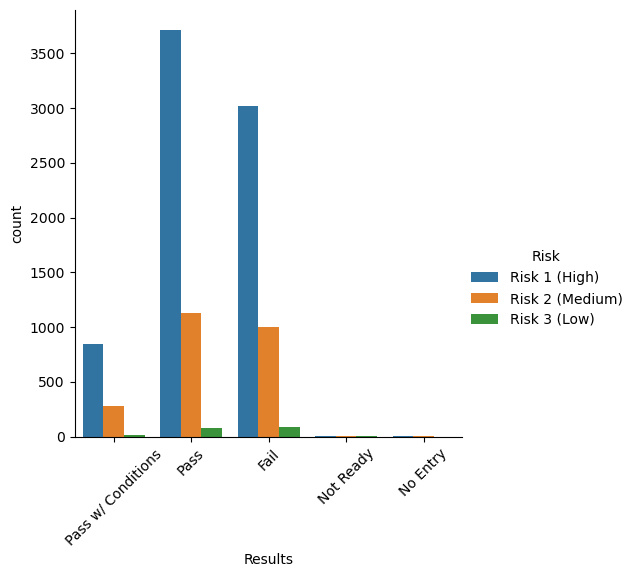

In [27]:
# Categorical variable plot with seaborn catplot
sns.catplot(x="Results", hue="Risk", kind="count", data=restaurant_df)
plt.xticks(rotation=45)  
plt.show()

In [28]:
# Convert Risk into numerical values
risk_mapping = {
    'Risk 1 (High)': 3,
    'Risk 2 (Medium)': 2,
    'Risk 3 (Low)': 1
}
restaurant_df['Risk_numeric'] = restaurant_df['Risk'].map(risk_mapping)

# Convert Results into dummy variables
results_dummies = pd.get_dummies(restaurant_df['Results'], prefix='Results')
results_dummies = results_dummies * 1  # Convert True/False to 1/0 if needed
restaurant_df = pd.concat([restaurant_df, results_dummies], axis=1)

# Drop boolean columns
for col in restaurant_df.columns:
    if restaurant_df[col].dtype == bool:
        restaurant_df.drop(col, axis=1, inplace=True)

restaurant_df.head()

,Name,License_ID,Risk,zip,Inspection_Date,Results,Violations,Risk_numeric,Results_Fail,Results_No Entry,Results_Not Ready,Results_Pass,Results_Pass w/ Conditions
0,CHIPOTLE MEXICAN GRILL,2670642.0,Risk 1 (High),60613.0,2019,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",3,0,0,0,0,1
1,SUBWAY,2703766.0,Risk 1 (High),60661.0,2019,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",3,0,0,0,0,1
2,SWEET SHOT COOKIES,2688916.0,Risk 2 (Medium),60647.0,2019,Pass,49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Com...,2,0,0,0,1,0
3,CHIPOTLE MEXICAN GRILL,2670642.0,Risk 1 (High),60613.0,2019,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",3,1,0,0,0,0
4,SAME SAME,2689715.0,Risk 1 (High),60618.0,2019,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",3,0,0,0,0,1


In [29]:
# Convert date dtype to int
restaurant_df['Inspection_Date'] = restaurant_df['Inspection_Date'].astype(int)

# Reformat data of the independent variable X as a single-column array
X = restaurant_df['Results_Fail'].values.reshape(-1, 1)

# Display sample data
X[:5]

array([[0],
       [0],
       [0],
       [1],
       [0]])

In [30]:
# Create an array for the dependent variable y
y = restaurant_df["Inspection_Date"]

In [31]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [32]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Building the Linear Regression Model

In [33]:
# Create & fit model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [34]:
# Display slope, y-intercept, & best fit line formula
print(f"Model's slope: {model.coef_}")
print(f"Model's y-intercept: {model.intercept_}")
print(f"Model's formula: y = {model.intercept_} + {model.coef_[0]}X")

Model's slope: [-1.60511957]
Model's y-intercept: 2015.5411169744943
Model's formula: y = 2015.5411169744943 + -1.6051195735846027X


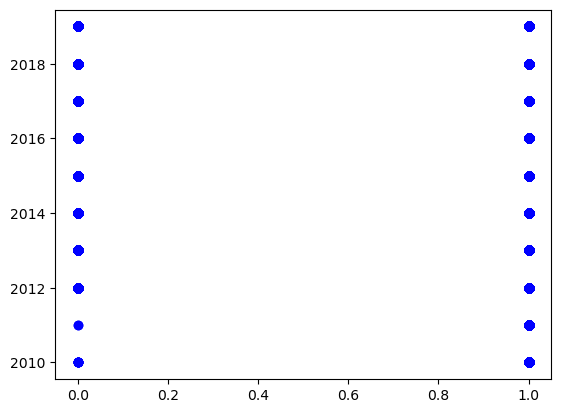

In [35]:
# Plot the training data (as a scatter plot)
plt.scatter(X_train.flatten(), y_train, color='blue', label='Training data')
plt.show()

In [36]:
# Plot the regression line using the formula for a line (y = mx + b)
x_range = np.arange(X.min(), X.max(), 0.1)  # This gives us a range of x values to apply our coefficients to
plt.plot(x_range, model.intercept_ + model.coef_[0] * x_range, color='red', label='Linear Regression Line')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

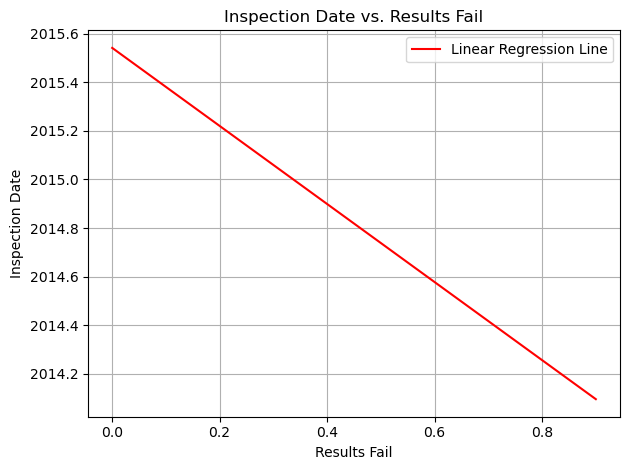

In [37]:
# Customize and show the plot
plt.title('Inspection Date vs. Results Fail')
plt.xlabel('Results Fail')
plt.ylabel('Inspection Date')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Model Assessment

In [39]:
# Compute the metrics for the linear regression model
score = model.score(X, y, sample_weight=None)
r2 = r2_score(X, y)
mse = mean_squared_error(X, y)
rmse = np.sqrt(mse)
std = np.std(y)

# Print relevant metrics.
print(f"The score is {score}.")
print(f"The r2 is {r2}.")
print(f"The mean squared error is {mse}.")
print(f"The root mean squared error is {rmse}.")
print(f"The standard deviation is {std}.")

The score is 0.08330154242116128.
The r2 is -16864620.065075804.
The mean squared error is 4058213.9659716757.
The root mean squared error is 2014.5009223059878.
The standard deviation is 2.7307447160888754.


In [40]:
# Define your independent variable (X) and dependent variable (y)
X = restaurant_df['Results_Fail']
y = restaurant_df['Inspection_Date']

# Add a constant to the independent variable(s)
X = sm.add_constant(X)

# Fit the model
model = sm.Logit(y, X).fit()

# Print out the model summary
print(model.summary())

ValueError: endog must be in the unit interval.